In [1]:
import os, sys
import numpy as np
import json
import random
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Preliminary

In [2]:
torch.manual_seed(12345)
k = 10000
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
hydrophobicity = {'G': 0, 'A': 41, 'L':97, 'M': 74, 'F':100, 'W':97, 'K':-23, 'Q':-10, 'E':-31, 'S':-5, 'P':-46, 'V':76, 'I':99, 'C':49, 'Y':63, 'H':8, 'R':-14, 'N':-28, 'D':-55, 'T':13}
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset

In [3]:
class BinaryDataset(Dataset):
    def __init__(self, filepath):
        def construct_binary_dataset(filepath):
            with open(filepath, 'r') as f:
                aptamer_data = json.load(f)
            ds = []
            for aptamer in aptamer_data:
                peptides = aptamer_data[aptamer]
                for peptide in peptides:
                    ds.append((aptamer, peptide, 1))
                    ds.append((get_x(), get_y(), 0))
            ds = list(set(ds)) #removed duplicates, random order
            return ds

        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x

        # Sample y from P_y (assume peptides follow NNK)
        def get_y():
            y_idx = np.random.choice(20, 7, p=pvals)
            y = "M"
            for i in y_idx:
                y += aa_list[i]
            return y

        self.binary_ds=construct_binary_dataset(filepath)

    def __len__(self):
        return len(self.binary_ds)

    def __getitem__(self,idx):
        return(self.binary_ds[idx])

In [4]:
binary_ds=BinaryDataset(filepath="../data/aptamer_dataset.json")
n = len(binary_ds)
m = int(0.8*n) #length of train
binary_train = binary_ds[:m]
binary_val = binary_ds[m:]

## NN Model

In [5]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.name = "LinearNet"
        
        self.fc_apt_1 = nn.Linear(160, 200) 
        self.fc_apt_2 = nn.Linear(200, 250)
        self.fc_apt_3 = nn.Linear(250, 300)
        
        self.fc_pep_1 = nn.Linear(160, 200)
        self.fc_pep_2 = nn.Linear(200, 250)
        
        self.relu = nn.ReLU()
        
        self.fc_apt = nn.Sequential(self.fc_apt_1, self.fc_apt_2, self.fc_apt_3)
        self.fc_pep = nn.Sequential(self.fc_pep_1, self.fc_pep_2)
        
        self.fc1 = nn.Linear(550, 600)
        self.fc2 = nn.Linear(600, 1)
        
    def forward(self, apt, pep):
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        apt = self.fc_apt(apt)
        pep = self.fc_pep(pep)
        x = torch.cat((apt, pep), 1)
        x = self.fc2(self.fc1(x))
        x = torch.sigmoid(x)
        return x

In [6]:
class LinearConv1d(nn.Module):
    def __init__(self):
        super(LinearConv1d, self).__init__()
        self.name = "LinearConv1d"
        
        self.cnn_apt_1 = nn.Conv1d(4, 10, 3) 
        self.cnn_apt_2 = nn.Conv1d(10, 25, 3) 
        self.cnn_apt_3 = nn.Conv1d(25, 50, 3) 
        self.cnn_apt_4 = nn.Conv1d(50, 100, 1) 
        
        self.cnn_pep_1 = nn.Conv1d(20, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 100, 1)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu,
                                     self.cnn_apt_3, self.maxpool, self.relu,
                                     self.cnn_apt_4, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(200, 200)
        self.fc2 = nn.Linear(200, 1)
    
    def forward(self, apt, pep):
        apt = apt.permute(0, 2, 1)
        pep = pep.permute(0, 2, 1)
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        #print(apt.size())
        #print(pep.size())
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [7]:
class ConvNetSimple(nn.Module):
    def __init__(self):
        super(ConvNetSimple, self).__init__()
        self.name = "ConvNetSimple"
        
        self.cnn_apt_1 = nn.Conv1d(4, 25, 3) 
        self.cnn_apt_2 = nn.Conv1d(25, 50, 3)
        self.cnn_apt_3 = nn.Conv1d(50, 100, 3)
        self.cnn_apt_4 = nn.Conv1d(100, 250, 1)
        
        self.cnn_pep_1 = nn.Conv1d(20, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 100, 3)
        self.cnn_pep_3 = nn.Conv1d(100, 250, 1)
       
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(500, 550)
        self.fc2 = nn.Linear(550, 600)
        self.fc3 = nn.Linear(600, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        apt = self.pool1(self.relu(self.cnn_apt_1(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_2(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_4(apt)))
        
        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)

        pep = self.relu(self.cnn_pep_1(pep))
        pep = self.pool1(self.relu(self.cnn_pep_2(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_3(pep)))
    
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc3(self.fc2(self.fc1(x)))
        x = torch.sigmoid(x)
        return x

In [8]:
class ConvNetComplex(nn.Module):
    def __init__(self):
        super(ConvNetComplex, self).__init__()
        self.name = "ConvNetComplex"
        
        self.cnn_apt_1 = nn.Conv1d(4, 25, 3) 
        self.cnn_apt_2 = nn.Conv1d(25, 50, 3)
        self.cnn_apt_3 = nn.Conv1d(50, 100, 3)
        self.cnn_apt_4 = nn.Conv1d(100, 200, 3)
        self.cnn_apt_5 = nn.Conv1d(200, 400, 1)
        self.cnn_apt_6 = nn.Conv1d(400, 800, 1)
        
        self.cnn_pep_1 = nn.Conv1d(20, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 100, 1)
        self.cnn_pep_3 = nn.Conv1d(100, 200, 1)
        self.cnn_pep_4 = nn.Conv1d(200, 400, 1)
        self.cnn_pep_5 = nn.Conv1d(400, 800, 1)
        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(1600, 1800)
        self.fc2 = nn.Linear(1800, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        apt = self.relu(self.cnn_apt_1(apt))
        apt = self.relu(self.cnn_apt_2(apt))
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_4(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_5(apt)))        
        apt = self.pool1(self.relu(self.cnn_apt_6(apt)))        

        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)
        
        pep = self.relu(self.cnn_pep_1(pep))
        pep = self.relu(self.cnn_pep_2(pep))
        pep = self.relu(self.cnn_pep_3(pep))
        pep = self.pool1(self.relu(self.cnn_pep_4(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_5(pep)))
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc2(self.fc1(x))
        x = torch.sigmoid(x)
        return x
        

In [9]:
class SingleAlphabetNet(nn.Module):
    def __init__(self):
        super(SingleAlphabetNet, self).__init__()
        self.name = "SingleAlphabetNet"
        
        self.cnn_1 = nn.Conv1d(24, 25, 3) 
        self.cnn_2 = nn.Conv1d(25, 50, 3)
        self.cnn_3 = nn.Conv1d(50, 100, 3)
        self.cnn_4 = nn.Conv1d(100, 200, 3)
        self.cnn_5 = nn.Conv1d(200, 400, 1)
        self.cnn_6 = nn.Conv1d(400, 800, 1)
        
        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(1600, 1800)
        self.fc2 = nn.Linear(1800, 1)
        
    def forward(self, pair):
        # pair input size [1, 48, 24]
        pair = pair.permute(0, 2, 1)
        
        pair = self.relu(self.cnn_1(pair))
        pair = self.relu(self.cnn_2(pair))
        pair = self.pool1(self.relu(self.cnn_3(pair)))
        pair = self.pool1(self.relu(self.cnn_4(pair)))
        pair = self.pool1(self.relu(self.cnn_5(pair)))        
        pair = self.pool1(self.relu(self.cnn_6(pair)))        

        pair = pair.view(-1, 1).T
        
        pair = self.fc2(self.fc1(pair))
        x = torch.sigmoid(pair)
        return x

In [10]:
class SingleAlphabetComplexNet(nn.Module):
    def __init__(self):
        super(SingleAlphabetComplexNet, self).__init__()
        self.name = "SingleAlphabetComplexNet"
        
        self.cnn_1 = nn.Conv1d(24, 50, 3) 
        self.cnn_2 = nn.Conv1d(50, 100, 3)
        self.cnn_3 = nn.Conv1d(100, 200, 3)
        self.cnn_4 = nn.Conv1d(200, 400, 3)
        self.cnn_5 = nn.Conv1d(400, 800, 3)
        self.cnn_6 = nn.Conv1d(800, 1000, 3, padding=2)
        self.cnn_7 = nn.Conv1d(1000, 800, 3, padding=2)
        self.cnn_8 = nn.Conv1d(800, 700, 3, padding=2)
        self.cnn_9 = nn.Conv1d(700, 500, 1)
        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(500, 1800)
        self.fc2 = nn.Linear(1800, 1)
        
    def forward(self, pair):
        # pair input size [1, 48, 24]
        pair = pair.permute(0, 2, 1)
        
        pair = self.relu(self.cnn_1(pair))
        pair = self.relu(self.cnn_2(pair))
        pair = self.pool1(self.relu(self.cnn_3(pair)))
        pair = self.pool1(self.relu(self.cnn_4(pair)))
        pair = self.pool1(self.relu(self.cnn_5(pair)))        
        pair = self.pool1(self.relu(self.cnn_6(pair)))
        pair = self.pool1(self.relu(self.cnn_7(pair))) 
        pair = self.pool1(self.relu(self.cnn_8(pair)))
        pair = self.pool1(self.relu(self.cnn_9(pair))) 

        pair = pair.view(-1, 1).T
        
        pair = self.fc2(self.fc1(pair))
        x = torch.sigmoid(pair)
        return x

In [11]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

## Helper methods

In [12]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        apt = sequence[0]
        pep = sequence[1]
        one_hot = np.zeros((len(apt) + len(pep), 24))
        # Encode the aptamer first
        for i in range(len(apt)):
            char = apt[i]
            for _ in range(len(na_list)):
                idx = na_list.index(char)
                one_hot[i][idx] = 1
            
        # Encode the peptide second
        for i in range(len(pep)):
            char = pep[i]
            for _ in range(len(aa_list)):
                idx = aa_list.index(char) + len(na_list)
                one_hot[i+len(apt)][idx] = 1
        
        return one_hot       
    else:
        if seq_type == 'peptide':
            letters = aa_list
        else:
            letters = na_list
        one_hot = np.zeros((len(sequence), len(letters)))
        for i in range(len(sequence)):
            char = sequence[i]
            for _ in range(len(letters)):
                idx = letters.index(char)
                one_hot[i][idx] = 1
        return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep, label, single_alphabet=False): 
    if single_alphabet:
        pair = one_hot([apt, pep], single_alphabet=True)
        pair = torch.FloatTensor(np.reshape(pair, (-1, pair.shape[0], pair.shape[1]))).to(device)
        label = torch.FloatTensor([label]).to(device)
        return pair, label
    else:
        apt = one_hot(apt, seq_type='aptamer') #(40, 4)
        pep = one_hot(pep, seq_type='peptide') #(8, 20)
        apt = torch.FloatTensor(np.reshape(apt, (-1, apt.shape[0], apt.shape[1]))).to(device) #(1, 40, 4)
        pep = torch.FloatTensor(np.reshape(pep, (-1, pep.shape[0], pep.shape[1]))).to(device) #(1, 8, 20)
        label = torch.FloatTensor([label]).to(device)
        return apt, pep, label

# Getting the output of the model for a pair (aptamer, peptide)
def update(x, y, p, single_alphabet=False):
    if single_alphabet:
        p.requires_grad=True
        p = p.to(device)
        out = model(p)
        return out
    else:
        x.requires_grad=True
        y.requires_grad=True
        x = x.to(device)
        y = y.to(device)
        out = model(x, y)
        return out

## Plotting functions
def plot_loss(iters, train_losses, val_losses, model_name, model_id):
    plt.title("Training Loss Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/%s/loss.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_accuracy(iters, train_acc, val_acc, model_name, model_id):
    plt.title("Training Accuracy Curve")
    plt.plot(train_acc, label="Train")
    plt.plot(val_acc, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/%s/accuracy.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_histogram(train_gen_scores, train_scores, val_gen_scores, val_scores, model_name, model_id):
    fig, ax = plt.subplots()
    plt.xlim(0, 1.1)
    
    sns.distplot(train_gen_scores , color="skyblue", label='Generated Train Samples', ax=ax)
    sns.distplot(train_scores , color="gold", label='Dataset Train Samples', ax=ax)
    sns.distplot(val_gen_scores, color='greenyellow', label='Generated Validation Samples')
    sns.distplot(val_scores, color='red', label='Dataset Validation Samples', ax=ax)
    ax.set_title("Categorizing the output scores of the model")
    ax.figure.set_size_inches(7, 4)
    ax.legend()
    plt.savefig('plots/binary/%s/%s/histogram.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

# TODO: Modify these to be for binary classification
def plot_ecdf_test(test_score, iters, epoch, lamb, gamma, model_name, model_id):
    test_idx = np.argsort(test_score)
    test_id = test_idx >= 10000
    test = np.sort(test_score)
    test_c = ""
    for m in test_id:
        if m:
            test_c += "y"
        else:
            test_c += "g"
    n = test_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, test, c=test_c, label='Test CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples after training %d samples" %iters)
    plt.title('Test CDF at epoch %d' %epoch+ " Lambda :%.5f" %lamb + ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/mle/%s/%s/test_cdf.png' %(model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_ecdf_train(train_score, iters, epoch, lamb, gamma, model_name, model_id):
    train_idx = np.argsort(train_score)
    train_id = train_idx >= 10000
    train = np.sort(train_score)
    train_c = "" #colors
    for l in train_id:
        if l:
            train_c += "r"
        else:
            train_c += "b"
    n = train_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, train, c=train_c, label='Train CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples after training %d samples" %iters)
    plt.title('Train CDF at epoch %d' %epoch+ " Lambda :%.5f" %lamb + ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/mle/%s/%s/train_cdf.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

In [13]:
# Test the regular one_hot method
oh = one_hot('LL', seq_type='peptide')
print(str(oh.shape))

(2, 20)


In [14]:
# Test the one_hot method
oh = one_hot(["GGGG", "LL"], single_alphabet=True)

## Binary Classification

In [15]:
def classifier(model, 
               train, 
               val,
               lr,
               model_id,
               num_epochs=50,
               batch_size=16,
               single_alphabet=False,
               run_from_checkpoint=None, 
               save_checkpoints=None):
    
    if run_from_checkpoint is not None:
        checkpointed_model = run_from_checkpoint
        checkpoint = torch.load(checkpointed_model)
        optimizer = SGD(model.parameters(), lr=5e-3)
        model.load_state_dict(checkpoint['model_state_dict'])
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        init_epoch = checkpoint['epoch']
        print("Reloading model: ", model.name, " at epoch: ", init_epoch)
    else:
        model.apply(weights_init)
    
    train_losses, val_losses, train_losses_avg, val_losses_avg, train_acc, val_acc = [], [], [], [], [], []
    iters, train_correct, val_correct = 0, 0, 0
    criterion = nn.BCELoss()
    optimizer = SGD(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=3, gamma=0.9) #Decays lr by gamma factor every step_size epochs. 
    
    # Keep track of the scores across four classes
    train_scores, train_gen_scores, val_scores, val_gen_scores = [], [], [], []
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        full_epoch = epoch + init_epoch
        scheduler.step()
        print("Starting epoch: %d" % full_epoch, " with learning rate: ", scheduler.get_lr())
        for (apt, pep, label) in train:
            model_name = model.name
            model.train()
            if single_alphabet:
                p, l = convert(apt, pep, label, single_alphabet=True)
                train_score = update(None, None, p, single_alphabet=True)
            else:
                a, p, l = convert(apt, pep, label, single_alphabet=False)
                train_score = update(a, p, None, single_alphabet=False)
                
            if (train_score.item() >= 0.5 and label == 1.0) or (train_score.item() <= 0.5 and label == 0.0):
                train_correct += 1
            
            if label == 0.0:
                train_gen_scores.append(train_score.item())
            elif label == 1.0:
                train_scores.append(train_score.item())
                
            iters += 1
            train_loss = criterion(train_score, l) 
            total_train_loss += train_loss
            
            if iters % batch_size == 0:
                ave_train_loss = total_train_loss/batch_size
                train_losses.append(ave_train_loss.item())
                optimizer.zero_grad()
                ave_train_loss.backward()
                optimizer.step()
                total_train_loss = 0

            if iters % 5000 == 0:
                train_acc.append(100*train_correct/iters)
                train_losses_avg.append(np.average(train_losses[-5000:]))

            with torch.no_grad():
                model.eval()
            
            if single_alphabet:
                p_val, l_val = convert(val[iters%(n-m)][0], val[iters%(n-m)][1], val[iters%(n-m)][2], single_alphabet=True)
                val_score = model(p_val)
            else:
                a_val, p_val, l_val = convert(val[iters%(n-m)][0], val[iters%(n-m)][1], val[iters%(n-m)][2])
                val_score = model(a_val, p_val)
            if (val_score.item() >= 0.5 and val[iters%(n-m)][2] == 1.0) or (val_score.item() <= 0.5 and val[iters%(n-m)][2] == 0.0):
                val_correct += 1
            
            if l_val.item() == 1.0:
                val_scores.append(val_score.item())
            if l_val.item() == 0.0:
                val_gen_scores.append(val_score.item())

            val_loss = criterion(val_score, l_val) 
            total_val_loss += val_loss
            if iters % batch_size == 0:
                ave_val_loss = total_val_loss/batch_size
                val_losses.append(ave_val_loss.item())
                total_val_loss = 0
            if iters % 5000 == 0:
                val_acc.append(100*val_correct/iters)
                val_losses_avg.append(np.average(val_losses[-5000:]))

            if iters % 50000 == 0:
                plot_loss(iters, train_losses_avg, val_losses_avg, model_name, model_id)
                plot_accuracy(iters, train_acc, val_acc, model_name, model_id)
                plot_histogram(train_gen_scores, train_scores, val_gen_scores, val_scores, model_name, model_id)
                
                print("Training Accuracy at epoch %d: {}".format(train_acc[-1]) %epoch)
                print("Validation Accuracy epoch %d: {}".format(val_acc[-1]) %epoch)
        if save_checkpoints is not None:
            print("Saving to: ", save_checkpoints)
            checkpoint_name = save_checkpoints
            torch.save({'epoch': full_epoch,
                        'model_state_dict': model.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict()}, checkpoint_name)
        
        # Clear unused gpu memory at the end of the epoch
        if device == torch.cuda:
            torch.cuda.empty_cache()

/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:117: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Starting epoch: 0  with learning rate:  [0.1]


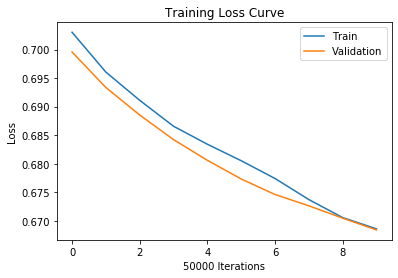

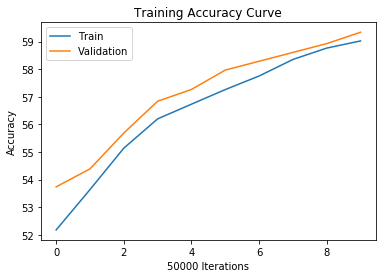

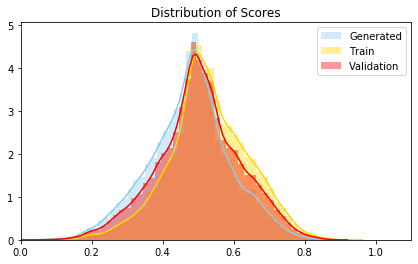

Training Accuracy at epoch 0: 59.022
Validation Accuracy epoch 0: 59.336


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


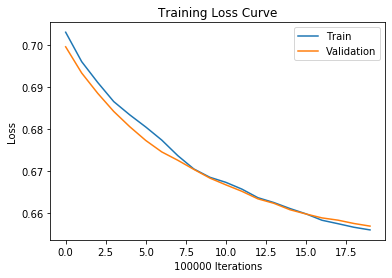

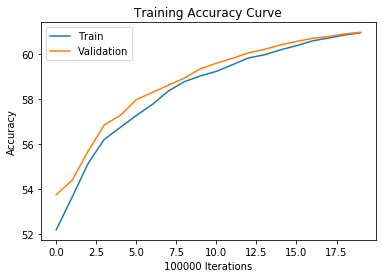

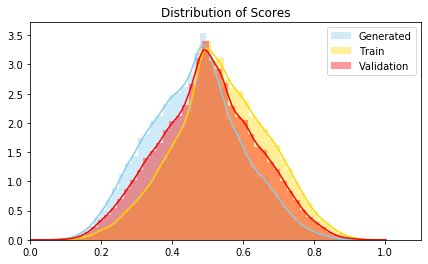

Training Accuracy at epoch 0: 60.938
Validation Accuracy epoch 0: 60.96


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


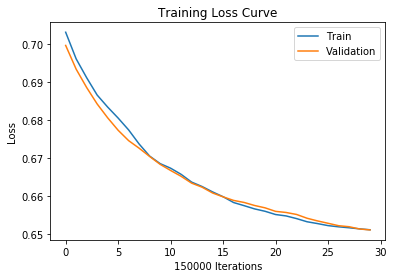

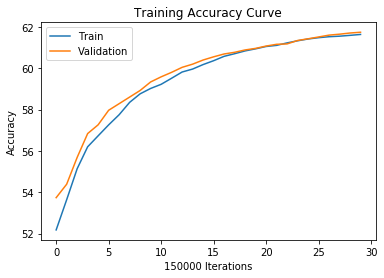

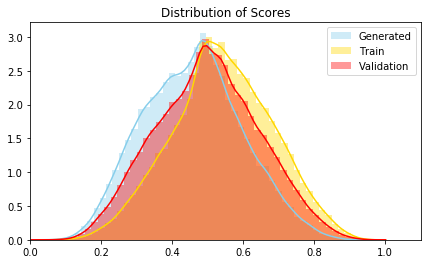

Training Accuracy at epoch 0: 61.634
Validation Accuracy epoch 0: 61.74066666666667


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


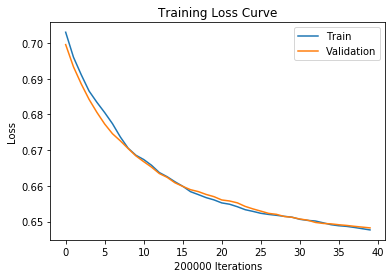

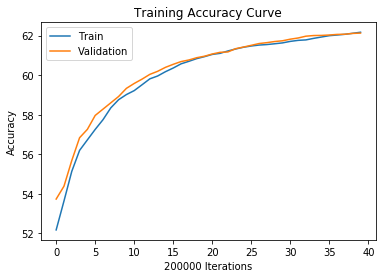

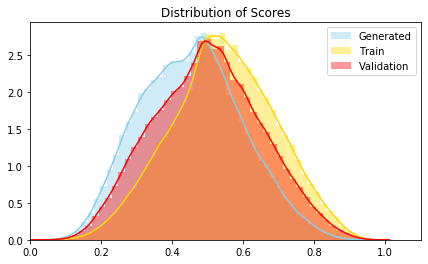

Training Accuracy at epoch 0: 62.1725
Validation Accuracy epoch 0: 62.129


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


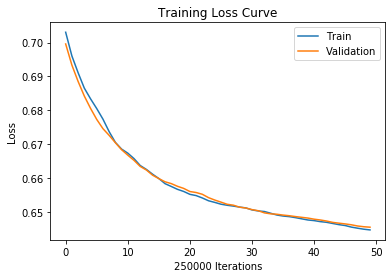

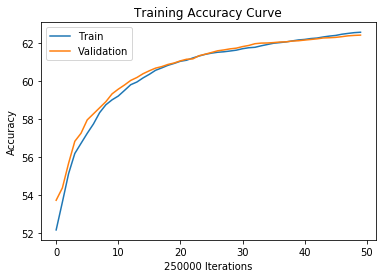

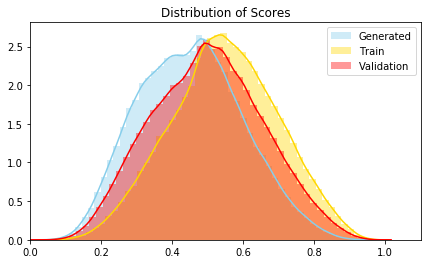

Training Accuracy at epoch 0: 62.5772
Validation Accuracy epoch 0: 62.4256


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


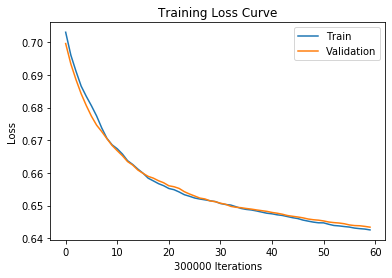

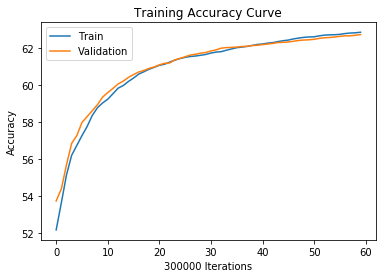

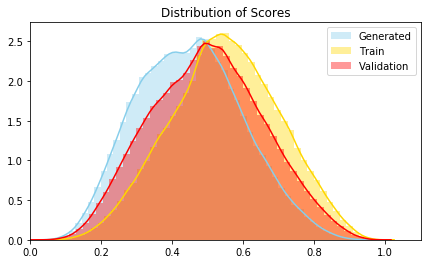

Training Accuracy at epoch 0: 62.83133333333333
Validation Accuracy epoch 0: 62.70366666666666


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


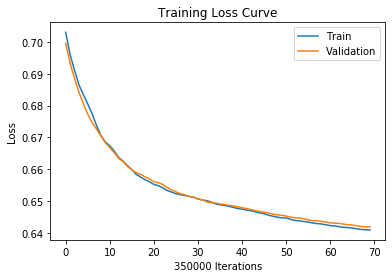

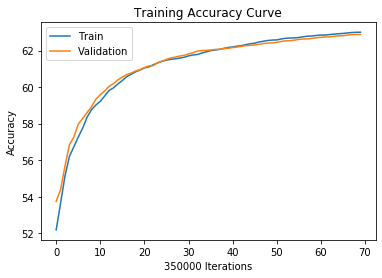

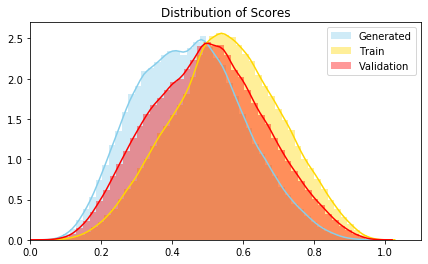

Training Accuracy at epoch 0: 63.00657142857143
Validation Accuracy epoch 0: 62.882


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


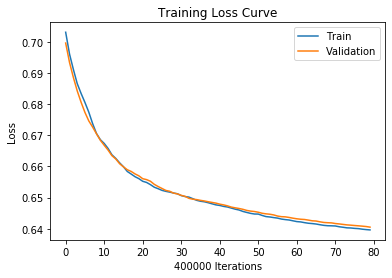

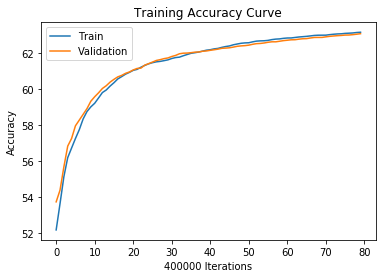

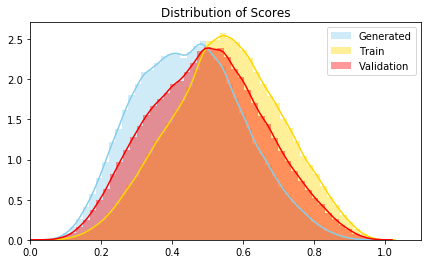

Training Accuracy at epoch 0: 63.17
Validation Accuracy epoch 0: 63.08975


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


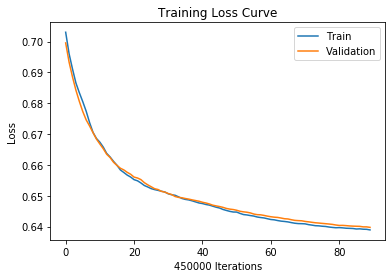

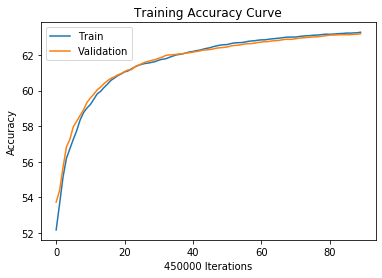

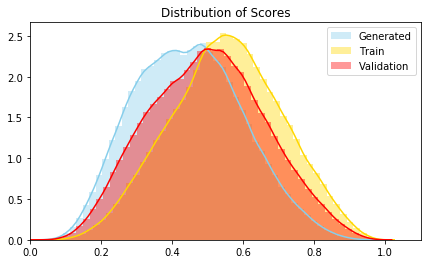

Training Accuracy at epoch 0: 63.27822222222222
Validation Accuracy epoch 0: 63.18977777777778


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


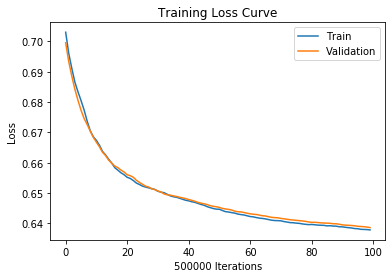

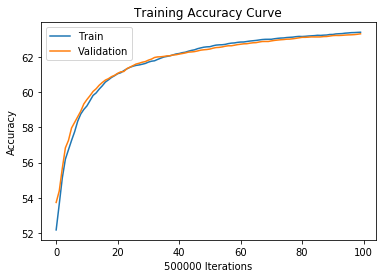

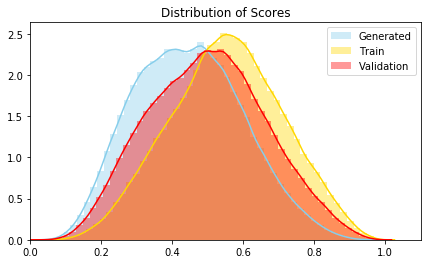

Training Accuracy at epoch 0: 63.4066
Validation Accuracy epoch 0: 63.3172


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


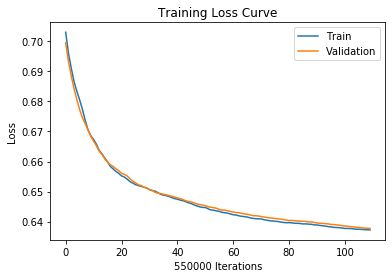

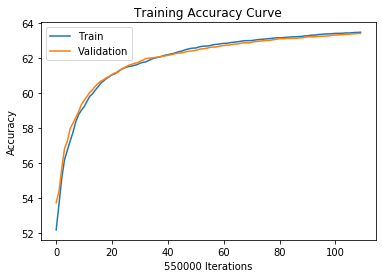

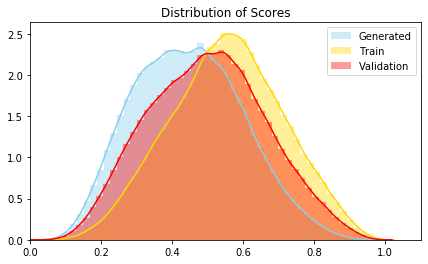

Training Accuracy at epoch 0: 63.48581818181818
Validation Accuracy epoch 0: 63.42109090909091


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


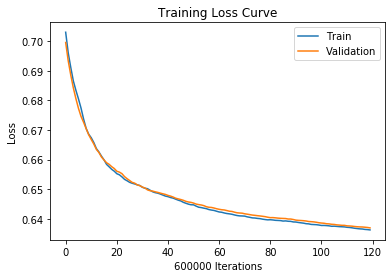

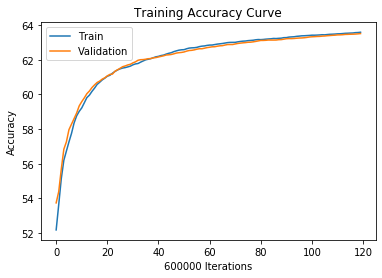

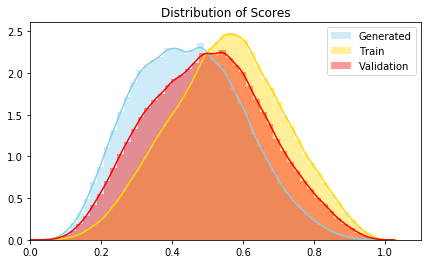

Training Accuracy at epoch 0: 63.590833333333336
Validation Accuracy epoch 0: 63.51416666666667


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


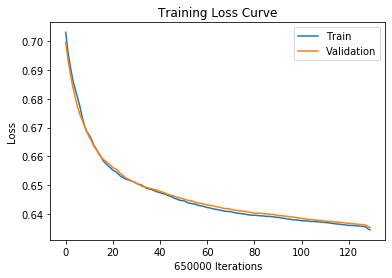

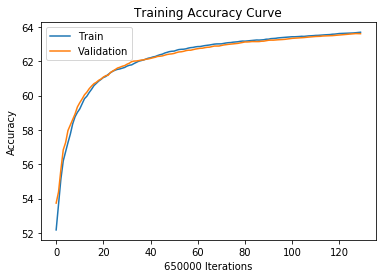

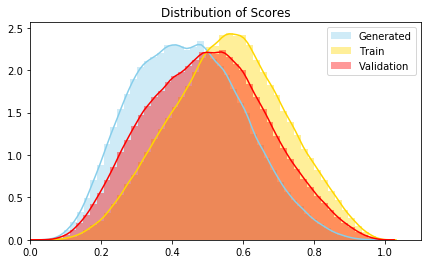

Training Accuracy at epoch 0: 63.684
Validation Accuracy epoch 0: 63.59892307692308


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


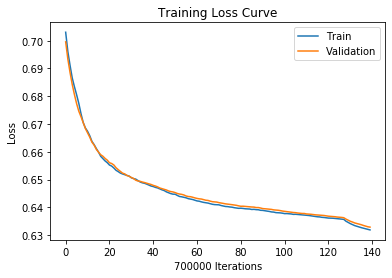

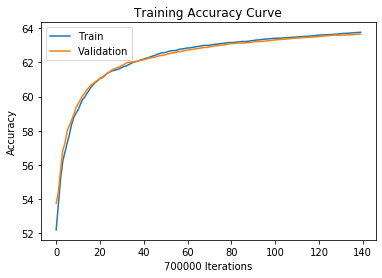

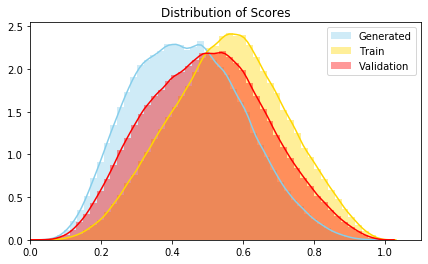

Training Accuracy at epoch 0: 63.77357142857143
Validation Accuracy epoch 0: 63.661857142857144


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


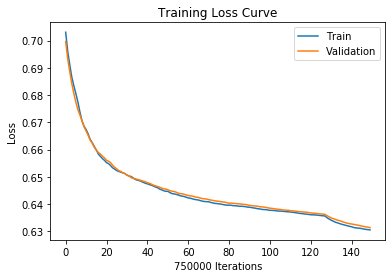

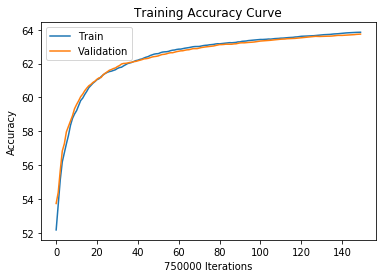

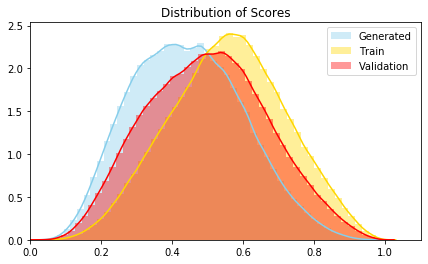

Training Accuracy at epoch 0: 63.84786666666667
Validation Accuracy epoch 0: 63.73693333333333


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


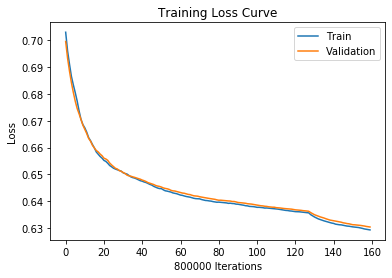

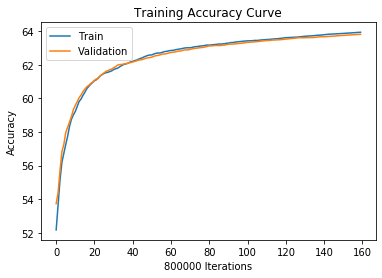

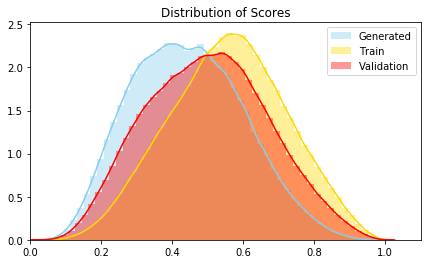

Training Accuracy at epoch 0: 63.930625
Validation Accuracy epoch 0: 63.810125


/ssd1/home/aishrm2/anaconda3/envs/aptamers/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


In [ ]:
model = SingleAlphabetComplexNet()
model_name = model.name
model_id = "06162020"
model.to(device)
checkpoint = 'model_checkpoints/binary/%s/%s.pth' % (model_name, model_id)
save_path = 'model_checkpoints/binary/%s/%s.pth' % (model_name, model_id)
single_alphabet = True
NUM_EPOCHS = 10
BATCH_SIZE = 128
gamma = 1e-1
classifier(model, binary_train, binary_val, gamma, model_id, NUM_EPOCHS, BATCH_SIZE, single_alphabet, checkpoint, save_path)